In [40]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.cluster import KMeans
from io import StringIO

In [41]:
k = 3
m = 60
m_cluster_sample_size = int(m/4)
normal_stdvar = 0.08
noise_stdvar = 0.45

In [42]:
#Set up random generation object
rng = np.random.default_rng()

#generate m random points in the square [0,1]*[0,1]
#Four sets of points are generated by different normal distributions.
#Three represent "clusterable" points, and a fourth is just noise.
#The sum of the four sets are of length "m"
points_cluster_1 = rng.normal(
    loc=(0, 0), 
    scale=normal_stdvar, 
    size=(m_cluster_sample_size,2))

points_cluster_2 = rng.normal(
    loc=(0, 0.8), 
    scale=normal_stdvar, 
    size=(m_cluster_sample_size,2))

points_cluster_3 = rng.normal(
    loc=(0.5, 0.5), 
    scale=normal_stdvar, 
    size=(m_cluster_sample_size,2))

points_noise = rng.normal(
    loc=(0.5, 0.5),
    scale=noise_stdvar, 
    size=(m_cluster_sample_size,2))

points = np.concatenate((points_cluster_1, points_cluster_2, points_cluster_3, points_noise))

#We normalize the points between [0,1]*[0,1], just in case the generators made points out of the scope.
points = (points-np.min(points))/(np.max(points)-np.min(points))

#generate matrix distance
dist = [[math.sqrt((i[0]-j[0])**2+(i[1]-j[1])**2) for i in points] for j in points]
print(len(dist[3]))


60


Text(0.5, 1.0, 'K means solution')

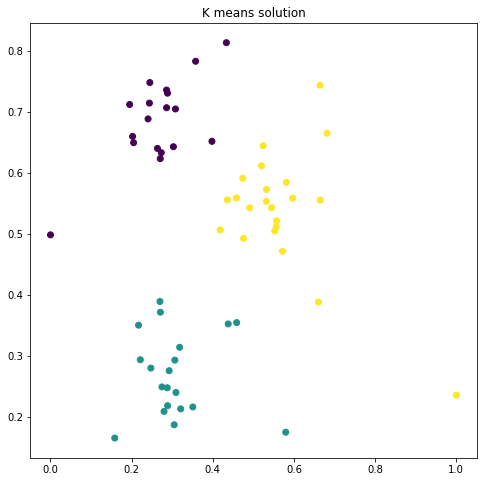

In [11]:
#Kmeans solution
random_state = 170
y_pred = KMeans(n_clusters=k, random_state=random_state).fit_predict(points)


#print clusters
plt.figure(figsize=(8, 8))


plt.scatter(points[:, 0], points[:, 1], c=y_pred)
plt.title("K means solution")

In [43]:
#We write the generated data in a .dat AMPL format.
output = open("Kcluster.dat", "w")
output.write('param k:= '+ str(k) + ';')
output.write('\n')
output.write('param m:= '+ str(m) + ';')
output.write('\n')
output.write('param d: ')
for i in range(m):output.write(str(i + 1) + ' ')
output.write(':=')
output.write('\n')
for i in range(m):
    output.write(str(i + 1) + ' ')
    for j in range(m):
        output.write(str(dist[i][j]))
        if(j != m-1):output.write(' ')
    if(i != m-1):output.write('\n')
output.write(';')
output.write('\n')
output.close()

<function matplotlib.pyplot.show(close=None, block=None)>

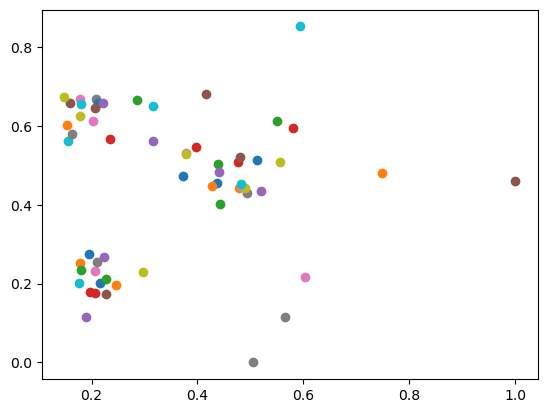

In [44]:
for point in points:
    plt.scatter(point[0], point[1])
plt.show

In [45]:
#We process the file to the CPLEX AMPL solver and read the result file.
solution_input = open("solution_matrix.txt", "r")
data_str =''
for line in solution_input.readlines():
    # Read all lines from the file and join them into a single string
    data_str = data_str + line

# Use StringIO to convert the string into a file-like object
data_file = StringIO(data_str)

# Skip the header lines and read the data into a DataFrame
df = pd.read_csv(data_file, delim_whitespace=True, skiprows=2, header=None)

# Set the column names to the values in the header row
header_row = data_str.splitlines()[1].split()
df = df.drop(12).drop(0, axis=1)

# Reset the index to match your data
df.reset_index(drop=True, inplace=True)

In [46]:
classification = dict()
for index, row in df.iterrows():
    selected_col = 1
    for value in row:
        if value == 1.0:
            if selected_col not in classification:
                classification[selected_col] = list()
            classification[selected_col].append(index)
        selected_col = selected_col + 1
    selected_col = 1

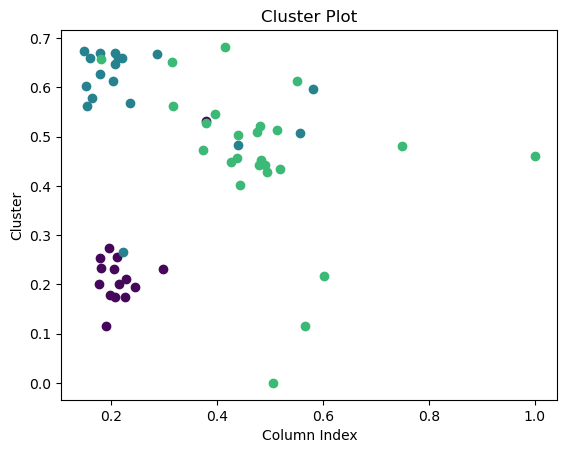

In [47]:
colors = np.linspace(0, 255, k)

viridis = mpl.colormaps['viridis'].resampled(len(points))

for cluster, color in zip(classification.keys(), colors):
    current_index_point = 0
    for point in points:
        if (current_index_point in classification[cluster]):
            plt.scatter(point[0], point[1], color=viridis(cluster), label=f'Cluster {cluster}')
        current_index_point = current_index_point + 1
    
plt.xlabel('Column Index')
plt.ylabel('Cluster')
plt.title('Cluster Plot')
plt.show()

In [48]:
df

,1,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
